In [1]:
"""
This lab for Pandas and PySpark interchange
And there has some connection testing to csv, parquet, and SQL Server
"""
#!pip install pyspark
#!pip install findspark
#!pip install pyodbc
#!pip install SQLAlchemy
#!pip install pyarrow
#!pip install numpy==1.26.3
#!pip install pymssql

'\nThis lab for Pandas and PySpark interchange\nAnd there has some connection testing to csv, parquet, and SQL Server\n'

In [10]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import numpy as np
import pandas as pd
from pyspark.sql.types import StringType, BinaryType, ArrayType, LongType, MapType
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf
import pyspark.pandas as ps
import pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('DataFrame').getOrCreate()

In [11]:
spark

In [4]:
spark.sparkContext
# <SparkContext master=local[*] appName=Analyzing the vocabulary of [...]>

<SparkContext master=local[*] appName=DataFrame>

In [5]:
from pyspark import SparkContext
#sc =SparkContext()

In [6]:
sc

''

In [7]:
spark.sparkContext.setLogLevel("WARN")

In [8]:
##read the dataset
##inferSchema means adjust the suitable data type for all columns. Otherwise they would be String
df_pyspark = spark.read.option('header','true').csv('df_VEH0120_GB.csv',inferSchema=True)

In [9]:
### Check the schema
df_pyspark.printSchema()

root
 |-- BodyType: string (nullable = true)
 |-- Make: string (nullable = true)
 |-- GenModel: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Fuel: string (nullable = true)
 |-- LicenceStatus: string (nullable = true)
 |-- 2024Q2: integer (nullable = true)
 |-- 2024Q1: integer (nullable = true)
 |-- 2023Q4: integer (nullable = true)
 |-- 2023Q3: integer (nullable = true)
 |-- 2023Q2: integer (nullable = true)
 |-- 2023Q1: integer (nullable = true)
 |-- 2022Q4: integer (nullable = true)
 |-- 2022Q3: integer (nullable = true)
 |-- 2022Q2: integer (nullable = true)
 |-- 2022Q1: integer (nullable = true)
 |-- 2021Q4: integer (nullable = true)
 |-- 2021Q3: integer (nullable = true)
 |-- 2021Q2: integer (nullable = true)
 |-- 2021Q1: integer (nullable = true)
 |-- 2020Q4: integer (nullable = true)
 |-- 2020Q3: integer (nullable = true)
 |-- 2020Q2: integer (nullable = true)
 |-- 2020Q1: integer (nullable = true)
 |-- 2019Q4: integer (nullable = true)
 |-- 2019Q3: integer

In [10]:
from pyspark.sql.functions import concat_ws
Vstat=df_pyspark.withColumn('id',concat_ws("::","BodyType","Make","GenModel","Model","Fuel","LicenceStatus"))
Vstat.select("BodyType","Make","GenModel","Model","Fuel","id").show(5)

+--------+------+-------------+--------------------+------+--------------------+
|BodyType|  Make|     GenModel|               Model|  Fuel|                  id|
+--------+------+-------------+--------------------+------+--------------------+
|    Cars|ABARTH|   ABARTH 124|     124 GT MULTIAIR|Petrol|Cars::ABARTH::ABA...|
|    Cars|ABARTH|   ABARTH 124|     124 GT MULTIAIR|Petrol|Cars::ABARTH::ABA...|
|    Cars|ABARTH|   ABARTH 124|124 GT MULTIAIR AUTO|Petrol|Cars::ABARTH::ABA...|
|    Cars|ABARTH|   ABARTH 124|124 GT MULTIAIR AUTO|Petrol|Cars::ABARTH::ABA...|
|    Cars|ABARTH|ABARTH SPIDER| 124 SPIDER MULTIAIR|Petrol|Cars::ABARTH::ABA...|
+--------+------+-------------+--------------------+------+--------------------+
only showing top 5 rows



In [11]:
from pyspark.sql.functions import col, split
lines = Vstat.select(split(col("id"), "::"))
lines

# DataFrame[split(value,  , -1): array<string>]
lines.printSchema()

root
 |-- split(id, ::, -1): array (nullable = false)
 |    |-- element: string (containsNull = false)



In [12]:
lines.show(5, truncate=100)

+--------------------------------------------------------------------+
|                                                   split(id, ::, -1)|
+--------------------------------------------------------------------+
|       [Cars, ABARTH, ABARTH 124, 124 GT MULTIAIR, Petrol, Licensed]|
|           [Cars, ABARTH, ABARTH 124, 124 GT MULTIAIR, Petrol, SORN]|
|  [Cars, ABARTH, ABARTH 124, 124 GT MULTIAIR AUTO, Petrol, Licensed]|
|      [Cars, ABARTH, ABARTH 124, 124 GT MULTIAIR AUTO, Petrol, SORN]|
|[Cars, ABARTH, ABARTH SPIDER, 124 SPIDER MULTIAIR, Petrol, Licensed]|
+--------------------------------------------------------------------+
only showing top 5 rows



In [13]:
def split(str, pattern, limit=-1):
    """ [... elided ] """
    sc = SparkContext._active_spark_context
    return Column(sc._jvm.functions.split(_to_java_column(str), pattern, limit))

In [14]:
from pyspark.sql.functions import col, split
Vstat.select(split(col("id"), "::")).printSchema()
# root
#  |-- split(value,  , -1): array (nullable = true)    ❶
#  |    |-- element: string (containsNull = true)
 
Vstat.select(split(col("id"), "::").alias("veh")).printSchema()
 
# root
#  |-- line: array (nullable = true)                   ❷
#  |    |-- element: string (containsNull = true)


root
 |-- split(id, ::, -1): array (nullable = false)
 |    |-- element: string (containsNull = false)

root
 |-- veh: array (nullable = false)
 |    |-- element: string (containsNull = false)



In [15]:
df_VStat = Vstat.unpivot("id",["2024Q2","2024Q1","2023Q4","2023Q3","2023Q2","2023Q1","2022Q4","2022Q3","2022Q2","2022Q1"\
                    ,"2021Q4","2021Q3","2021Q2","2021Q1","2020Q4","2020Q3","2020Q2","2020Q1","2019Q4","2019Q3","2019Q2","2019Q1"\
                    ,"2018Q4","2018Q3","2018Q2","2018Q1","2017Q4","2017Q3","2017Q2","2017Q1","2016Q4","2016Q3","2016Q2","2016Q1"\
                    ,"2015Q4","2015Q3","2015Q2","2015Q1","2014Q4","2014Q3","2014Q2","2014Q1","2013Q4","2013Q3","2013Q2","2013Q1"\
                    ,"2012Q4","2012Q3","2012Q2","2012Q1","2011Q4","2011Q3","2011Q2","2011Q1","2010Q4","2010Q3","2010Q2","2010Q1"\
                    ,"2009Q4","2009Q3","2009Q2","2009Q1","2008Q4","2008Q3","2007Q4","2006Q4","2005Q4","2004Q4","2003Q4","2002Q4"\
                    ,"2001Q4","2000Q4","1999Q4","1998Q4","1997Q4","1996Q4","1995Q4","1994Q4"\
                   ],"Period","Counting")

In [16]:
#df_VStat.write.parquet("df_VEH0120_GB_p1.parquet")

In [17]:
df_pyspark_vh=spark.read.csv('LanmanWorkstation Parameters.csv',header=True,inferSchema=True)
df_pyspark_vh.show()

+-------------------+--------------------+--------------------+------------+--------------------+
|       RegistryPath|                Path|                Name|        Kind|               Value|
+-------------------+--------------------+--------------------+------------+--------------------+
|HiveKeyLocalMachine|System\CurrentCon...|EnablePlainTextPa...|       DWord|            00000000|
|HiveKeyLocalMachine|System\CurrentCon...|EnableSecuritySig...|       DWord|            00000001|
|HiveKeyLocalMachine|System\CurrentCon...|RequireSecuritySi...|       DWord|            00000000|
|HiveKeyLocalMachine|System\CurrentCon...|          ServiceDll|ExpandString|C:\WINDOWS\System...|
|HiveKeyLocalMachine|System\CurrentCon...|ServiceDllUnloadO...|       DWord|            00000001|
|HiveKeyLocalMachine|System\CurrentCon...|     AuditSmb1Access|       DWord|            00000000|
+-------------------+--------------------+--------------------+------------+--------------------+



In [18]:
type(df_pyspark)

pyspark.sql.dataframe.DataFrame

In [19]:
df_pyspark_vh.columns

['RegistryPath', 'Path', 'Name', 'Kind', 'Value']

In [20]:
df_pyspark.head(1)

[Row(BodyType='Cars', Make='ABARTH', GenModel='ABARTH 124', Model='124 GT MULTIAIR', Fuel='Petrol', LicenceStatus='Licensed', 2024Q2=16, 2024Q1=16, 2023Q4=16, 2023Q3=16, 2023Q2=17, 2023Q1=17, 2022Q4=17, 2022Q3=17, 2022Q2=18, 2022Q1=18, 2021Q4=16, 2021Q3=18, 2021Q2=18, 2021Q1=17, 2020Q4=18, 2020Q3=18, 2020Q2=18, 2020Q1=18, 2019Q4=18, 2019Q3=18, 2019Q2=18, 2019Q1=17, 2018Q4=12, 2018Q3=2, 2018Q2=0, 2018Q1=0, 2017Q4=0, 2017Q3=0, 2017Q2=0, 2017Q1=0, 2016Q4=0, 2016Q3=0, 2016Q2=0, 2016Q1=0, 2015Q4=0, 2015Q3=0, 2015Q2=0, 2015Q1=0, 2014Q4=0, 2014Q3=0, 2014Q2=0, 2014Q1=0, 2013Q4=0, 2013Q3=0, 2013Q2=0, 2013Q1=0, 2012Q4=0, 2012Q3=0, 2012Q2=0, 2012Q1=0, 2011Q4=0, 2011Q3=0, 2011Q2=0, 2011Q1=0, 2010Q4=0, 2010Q3=0, 2010Q2=0, 2010Q1=0, 2009Q4=0, 2009Q3=0, 2009Q2=0, 2009Q1=0, 2008Q4=0, 2008Q3=0, 2007Q4=0, 2006Q4=0, 2005Q4=0, 2004Q4=0, 2003Q4=0, 2002Q4=0, 2001Q4=0, 2000Q4=0, 1999Q4=0, 1998Q4=0, 1997Q4=0, 1996Q4=0, 1995Q4=0, 1994Q4=0)]

In [21]:
type(df_pyspark.select('2024Q2'))

pyspark.sql.dataframe.DataFrame

In [22]:
df_pyspark.dtypes

[('BodyType', 'string'),
 ('Make', 'string'),
 ('GenModel', 'string'),
 ('Model', 'string'),
 ('Fuel', 'string'),
 ('LicenceStatus', 'string'),
 ('2024Q2', 'int'),
 ('2024Q1', 'int'),
 ('2023Q4', 'int'),
 ('2023Q3', 'int'),
 ('2023Q2', 'int'),
 ('2023Q1', 'int'),
 ('2022Q4', 'int'),
 ('2022Q3', 'int'),
 ('2022Q2', 'int'),
 ('2022Q1', 'int'),
 ('2021Q4', 'int'),
 ('2021Q3', 'int'),
 ('2021Q2', 'int'),
 ('2021Q1', 'int'),
 ('2020Q4', 'int'),
 ('2020Q3', 'int'),
 ('2020Q2', 'int'),
 ('2020Q1', 'int'),
 ('2019Q4', 'int'),
 ('2019Q3', 'int'),
 ('2019Q2', 'int'),
 ('2019Q1', 'int'),
 ('2018Q4', 'int'),
 ('2018Q3', 'int'),
 ('2018Q2', 'int'),
 ('2018Q1', 'int'),
 ('2017Q4', 'int'),
 ('2017Q3', 'int'),
 ('2017Q2', 'int'),
 ('2017Q1', 'int'),
 ('2016Q4', 'int'),
 ('2016Q3', 'int'),
 ('2016Q2', 'int'),
 ('2016Q1', 'int'),
 ('2015Q4', 'int'),
 ('2015Q3', 'int'),
 ('2015Q2', 'int'),
 ('2015Q1', 'int'),
 ('2014Q4', 'int'),
 ('2014Q3', 'int'),
 ('2014Q2', 'int'),
 ('2014Q1', 'int'),
 ('2013Q4', 'int

In [23]:
#checking dataframe structure
df_pyspark.describe()

DataFrame[summary: string, BodyType: string, Make: string, GenModel: string, Model: string, Fuel: string, LicenceStatus: string, 2024Q2: string, 2024Q1: string, 2023Q4: string, 2023Q3: string, 2023Q2: string, 2023Q1: string, 2022Q4: string, 2022Q3: string, 2022Q2: string, 2022Q1: string, 2021Q4: string, 2021Q3: string, 2021Q2: string, 2021Q1: string, 2020Q4: string, 2020Q3: string, 2020Q2: string, 2020Q1: string, 2019Q4: string, 2019Q3: string, 2019Q2: string, 2019Q1: string, 2018Q4: string, 2018Q3: string, 2018Q2: string, 2018Q1: string, 2017Q4: string, 2017Q3: string, 2017Q2: string, 2017Q1: string, 2016Q4: string, 2016Q3: string, 2016Q2: string, 2016Q1: string, 2015Q4: string, 2015Q3: string, 2015Q2: string, 2015Q1: string, 2014Q4: string, 2014Q3: string, 2014Q2: string, 2014Q1: string, 2013Q4: string, 2013Q3: string, 2013Q2: string, 2013Q1: string, 2012Q4: string, 2012Q3: string, 2012Q2: string, 2012Q1: string, 2011Q4: string, 2011Q3: string, 2011Q2: string, 2011Q1: string, 2010Q4:

In [24]:
##Adding columns in data frame by self-declare formula
df_pyspark=df_pyspark.withColumn('2024Q2 plus 3', df_pyspark['2024Q2'] + 3)

In [25]:
df_pyspark.select("BodyType","Make","Model","2024Q2","2024Q2 plus 3").show()
df_pyspark.dtypes

+--------+------+--------------------+------+-------------+
|BodyType|  Make|               Model|2024Q2|2024Q2 plus 3|
+--------+------+--------------------+------+-------------+
|    Cars|ABARTH|     124 GT MULTIAIR|    16|           19|
|    Cars|ABARTH|     124 GT MULTIAIR|     3|            6|
|    Cars|ABARTH|124 GT MULTIAIR AUTO|    24|           27|
|    Cars|ABARTH|124 GT MULTIAIR AUTO|     2|            5|
|    Cars|ABARTH| 124 SPIDER MULTIAIR|   964|          967|
|    Cars|ABARTH| 124 SPIDER MULTIAIR|    26|           29|
|    Cars|ABARTH|124 SPIDER MULTIA...|   648|          651|
|    Cars|ABARTH|124 SPIDER MULTIA...|    24|           27|
|    Cars|ABARTH|124 SPIDER SCORPI...|    60|           63|
|    Cars|ABARTH|124 SPIDER SCORPI...|     1|            4|
|    Cars|ABARTH|                 500|  3716|         3719|
|    Cars|ABARTH|                 500|   339|          342|
|    Cars|ABARTH|               500 C|   145|          148|
|    Cars|ABARTH|               500 C|  

[('BodyType', 'string'),
 ('Make', 'string'),
 ('GenModel', 'string'),
 ('Model', 'string'),
 ('Fuel', 'string'),
 ('LicenceStatus', 'string'),
 ('2024Q2', 'int'),
 ('2024Q1', 'int'),
 ('2023Q4', 'int'),
 ('2023Q3', 'int'),
 ('2023Q2', 'int'),
 ('2023Q1', 'int'),
 ('2022Q4', 'int'),
 ('2022Q3', 'int'),
 ('2022Q2', 'int'),
 ('2022Q1', 'int'),
 ('2021Q4', 'int'),
 ('2021Q3', 'int'),
 ('2021Q2', 'int'),
 ('2021Q1', 'int'),
 ('2020Q4', 'int'),
 ('2020Q3', 'int'),
 ('2020Q2', 'int'),
 ('2020Q1', 'int'),
 ('2019Q4', 'int'),
 ('2019Q3', 'int'),
 ('2019Q2', 'int'),
 ('2019Q1', 'int'),
 ('2018Q4', 'int'),
 ('2018Q3', 'int'),
 ('2018Q2', 'int'),
 ('2018Q1', 'int'),
 ('2017Q4', 'int'),
 ('2017Q3', 'int'),
 ('2017Q2', 'int'),
 ('2017Q1', 'int'),
 ('2016Q4', 'int'),
 ('2016Q3', 'int'),
 ('2016Q2', 'int'),
 ('2016Q1', 'int'),
 ('2015Q4', 'int'),
 ('2015Q3', 'int'),
 ('2015Q2', 'int'),
 ('2015Q1', 'int'),
 ('2014Q4', 'int'),
 ('2014Q3', 'int'),
 ('2014Q2', 'int'),
 ('2014Q1', 'int'),
 ('2013Q4', 'int

In [26]:
##Drop the colum
# Then check if the column just dropped still in the dataframe or not
df_pyspark=df_pyspark.drop('2024Q2 plus 3')
print("2024Q2 plus 3" in df_pyspark.columns)

False


In [27]:
df_pyspark.select("BodyType","Make","Model").show()
df_pyspark.dtypes

+--------+------+--------------------+
|BodyType|  Make|               Model|
+--------+------+--------------------+
|    Cars|ABARTH|     124 GT MULTIAIR|
|    Cars|ABARTH|     124 GT MULTIAIR|
|    Cars|ABARTH|124 GT MULTIAIR AUTO|
|    Cars|ABARTH|124 GT MULTIAIR AUTO|
|    Cars|ABARTH| 124 SPIDER MULTIAIR|
|    Cars|ABARTH| 124 SPIDER MULTIAIR|
|    Cars|ABARTH|124 SPIDER MULTIA...|
|    Cars|ABARTH|124 SPIDER MULTIA...|
|    Cars|ABARTH|124 SPIDER SCORPI...|
|    Cars|ABARTH|124 SPIDER SCORPI...|
|    Cars|ABARTH|                 500|
|    Cars|ABARTH|                 500|
|    Cars|ABARTH|               500 C|
|    Cars|ABARTH|               500 C|
|    Cars|ABARTH|           500 C S-A|
|    Cars|ABARTH|           500 C S-A|
|    Cars|ABARTH|          500 CUSTOM|
|    Cars|ABARTH|          500 CUSTOM|
|    Cars|ABARTH|      500 CUSTOM S-A|
|    Cars|ABARTH|      500 CUSTOM S-A|
+--------+------+--------------------+
only showing top 20 rows



[('BodyType', 'string'),
 ('Make', 'string'),
 ('GenModel', 'string'),
 ('Model', 'string'),
 ('Fuel', 'string'),
 ('LicenceStatus', 'string'),
 ('2024Q2', 'int'),
 ('2024Q1', 'int'),
 ('2023Q4', 'int'),
 ('2023Q3', 'int'),
 ('2023Q2', 'int'),
 ('2023Q1', 'int'),
 ('2022Q4', 'int'),
 ('2022Q3', 'int'),
 ('2022Q2', 'int'),
 ('2022Q1', 'int'),
 ('2021Q4', 'int'),
 ('2021Q3', 'int'),
 ('2021Q2', 'int'),
 ('2021Q1', 'int'),
 ('2020Q4', 'int'),
 ('2020Q3', 'int'),
 ('2020Q2', 'int'),
 ('2020Q1', 'int'),
 ('2019Q4', 'int'),
 ('2019Q3', 'int'),
 ('2019Q2', 'int'),
 ('2019Q1', 'int'),
 ('2018Q4', 'int'),
 ('2018Q3', 'int'),
 ('2018Q2', 'int'),
 ('2018Q1', 'int'),
 ('2017Q4', 'int'),
 ('2017Q3', 'int'),
 ('2017Q2', 'int'),
 ('2017Q1', 'int'),
 ('2016Q4', 'int'),
 ('2016Q3', 'int'),
 ('2016Q2', 'int'),
 ('2016Q1', 'int'),
 ('2015Q4', 'int'),
 ('2015Q3', 'int'),
 ('2015Q2', 'int'),
 ('2015Q1', 'int'),
 ('2014Q4', 'int'),
 ('2014Q3', 'int'),
 ('2014Q2', 'int'),
 ('2014Q1', 'int'),
 ('2013Q4', 'int

In [28]:
spark.read

In [29]:
dir(spark.read)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_df',
 '_jreader',
 '_set_opts',
 '_spark',
 'csv',
 'format',
 'jdbc',
 'json',
 'load',
 'option',
 'options',
 'orc',
 'parquet',
 'schema',
 'table',
 'text']

In [30]:
df_en = spark.read.option('header','true').csv('C:\\Data\\source\\EngagingNetworks\\Archive\\EngagingNetworks Test Data 2.8.csv',inferSchema=True)

In [31]:
df_en.select('Account ID','Supporter ID','Supporter Email','Campaign ID','Title','Postcode').filter(df_en['Supporter ID'].like("%161014313")).show(10, truncate=False)

+----------+------------+---------------------+------------------------------------------+-----+--------+
|Account ID|Supporter ID|Supporter Email      |Campaign ID                               |Title|Postcode|
+----------+------------+---------------------+------------------------------------------+-----+--------+
|2339      |161014313   |apirrey15@gizmodo.com|Become a Mind campaigner                  |Miss |CV32 5NA|
|2339      |161014313   |apirrey15@gizmodo.com|SMS or text Opt-in                        |Miss |CV32 5NA|
|2339      |161014313   |apirrey15@gizmodo.com|Shaping Mind's work                       |Miss |CV32 5NA|
|2339      |161014313   |apirrey15@gizmodo.com|Fundraising events and challenges         |Miss |CV32 5NA|
|2339      |161014313   |apirrey15@gizmodo.com|I want to choose what you contact me about|Miss |CV32 5NA|
|2339      |161014313   |apirrey15@gizmodo.com|Phone opt in                              |Miss |CV32 5NA|
|2339      |161014313   |apirrey15@gizmodo.com

In [32]:
df_en.dtypes

[('Account ID', 'int'),
 ('Supporter ID', 'int'),
 ('Supporter Email', 'string'),
 ('Date Created', 'string'),
 ('Date Modified', 'string'),
 ('Campaign Number', 'int'),
 ('Campaign Type', 'string'),
 ('Campaign ID', 'string'),
 ('Campaign Date', 'string'),
 ('Campaign Time', 'timestamp'),
 ('Campaign Status', 'string'),
 ('Campaign Data 1', 'string'),
 ('Campaign Data 2', 'string'),
 ('Campaign Data 3', 'string'),
 ('Campaign Data 4', 'string'),
 ('Campaign Data 5', 'string'),
 ('Campaign Data 6', 'string'),
 ('Campaign Data 7', 'string'),
 ('Campaign Data 8', 'string'),
 ('Campaign Data 9', 'string'),
 ('Campaign Data 10', 'string'),
 ('Campaign Data 11', 'string'),
 ('Campaign Data 12', 'string'),
 ('Campaign Data 13', 'string'),
 ('Campaign Data 14', 'string'),
 ('Campaign Data 15', 'string'),
 ('Campaign Data 16', 'string'),
 ('Campaign Data 17', 'string'),
 ('Campaign Data 18', 'string'),
 ('Campaign Data 19', 'string'),
 ('Campaign Data 20', 'string'),
 ('Campaign Data 21', 'str

In [33]:
#Create a table view for sql query
df_en.createOrReplaceTempView('eNet')
spark.sql("SELECT `Account ID`,`Supporter ID`,`Supporter Email`,`Campaign ID`, Postcode FROM eNet WHERE `Supporter ID` like '%161014313'").show()

+----------+------------+--------------------+--------------------+--------+
|Account ID|Supporter ID|     Supporter Email|         Campaign ID|Postcode|
+----------+------------+--------------------+--------------------+--------+
|      2339|   161014313|apirrey15@gizmodo...|Become a Mind cam...|CV32 5NA|
|      2339|   161014313|apirrey15@gizmodo...|  SMS or text Opt-in|CV32 5NA|
|      2339|   161014313|apirrey15@gizmodo...| Shaping Mind's work|CV32 5NA|
|      2339|   161014313|apirrey15@gizmodo...|Fundraising event...|CV32 5NA|
|      2339|   161014313|apirrey15@gizmodo...|I want to choose ...|CV32 5NA|
|      2339|   161014313|apirrey15@gizmodo...|        Phone opt in|CV32 5NA|
|      2339|   161014313|apirrey15@gizmodo...|        Email Opt-in|CV32 5NA|
+----------+------------+--------------------+--------------------+--------+



In [34]:
spark.catalog.listTables()

[Table(name='eNet', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [35]:
pc = spark.read.csv('C:\\Data\\source\\postcodes.csv',header=True,inferSchema=True)

In [36]:
pc.dtypes

[('Postcode', 'string'),
 ('In Use?', 'string'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Easting', 'int'),
 ('Northing', 'int'),
 ('Grid Ref', 'string'),
 ('County', 'string'),
 ('District', 'string'),
 ('Ward', 'string'),
 ('District Code', 'string'),
 ('Ward Code', 'string'),
 ('Country', 'string'),
 ('County Code', 'string'),
 ('Constituency', 'string'),
 ('Introduced', 'date'),
 ('Terminated', 'date'),
 ('Parish', 'string'),
 ('National Park', 'string'),
 ('Population', 'int'),
 ('Households', 'int'),
 ('Built up area', 'string'),
 ('Built up sub-division', 'string'),
 ('Lower layer super output area', 'string'),
 ('Rural/urban', 'string'),
 ('Region', 'string'),
 ('Altitude', 'int'),
 ('London zone', 'int'),
 ('LSOA Code', 'string'),
 ('Local authority', 'string'),
 ('MSOA Code', 'string'),
 ('Middle layer super output area', 'string'),
 ('Parish Code', 'string'),
 ('Census output area', 'string'),
 ('Constituency Code', 'string'),
 ('Index of Multiple Deprivation', 

In [37]:
#Create another table view Psc for join query
pc.createOrReplaceTempView('Psc')
spark.sql("SELECT eNet.`Account ID`,eNet.`Supporter ID`,eNet.`Supporter Email`,eNet.`Campaign ID`, eNet.Postcode, Psc.`Altitude` \
FROM eNet left join Psc on eNet.Postcode = Psc.Postcode WHERE `Supporter ID` like '%161014313'").show()

+----------+------------+--------------------+--------------------+--------+--------+
|Account ID|Supporter ID|     Supporter Email|         Campaign ID|Postcode|Altitude|
+----------+------------+--------------------+--------------------+--------+--------+
|      2339|   161014313|apirrey15@gizmodo...|Become a Mind cam...|CV32 5NA|      69|
|      2339|   161014313|apirrey15@gizmodo...|  SMS or text Opt-in|CV32 5NA|      69|
|      2339|   161014313|apirrey15@gizmodo...| Shaping Mind's work|CV32 5NA|      69|
|      2339|   161014313|apirrey15@gizmodo...|Fundraising event...|CV32 5NA|      69|
|      2339|   161014313|apirrey15@gizmodo...|I want to choose ...|CV32 5NA|      69|
|      2339|   161014313|apirrey15@gizmodo...|        Phone opt in|CV32 5NA|      69|
|      2339|   161014313|apirrey15@gizmodo...|        Email Opt-in|CV32 5NA|      69|
+----------+------------+--------------------+--------------------+--------+--------+



In [38]:
#Convert Spark DataFrame to Pandas
EnageNetwork = df_en.toPandas()

In [39]:
EnageNetwork.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 77 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Account ID             21 non-null     int32         
 1   Supporter ID           21 non-null     int32         
 2   Supporter Email        21 non-null     object        
 3   Date Created           21 non-null     object        
 4   Date Modified          7 non-null      object        
 5   Campaign Number        21 non-null     int32         
 6   Campaign Type          21 non-null     object        
 7   Campaign ID            21 non-null     object        
 8   Campaign Date          21 non-null     object        
 9   Campaign Time          21 non-null     datetime64[ns]
 10  Campaign Status        21 non-null     object        
 11  Campaign Data 1        18 non-null     object        
 12  Campaign Data 2        0 non-null      object        
 13  Campaig

In [40]:
#Setup variable for reading SQL Server
#Reading mssql server, it need to use Pandas, pyodbc, and sqlachemy
import pyodbc
import pandas as pd
import sqlalchemy as sa
# Set up the database connection

db_host = "127.0.0.1"
db_port = "1433"
db_name = "test"
db_user = "pyt"
db_password = "pyt1234"

In [41]:
# Connect SQL Server with Pyspark

#conn = pyodbc.connect(
#    "Driver={SQL Server};"
#    "Server=" + db_host + "," + db_port + ";"
#    "Database=" + db_name + ";"
#    "UID=" + db_user + ";"
#    "PWD=" + db_password + ";"
#)

#query = "SELECT * FROM dbo.postcode"
#df_pandas = pd.read_sql(query, conn)
from sqlalchemy.engine import URL
#connection_string = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=127.0.0.1;DATABASE=test;UID=pyt;PWD=pyt1234;"
connection_string = "DRIVER={ODBC Driver 17 for SQL Server};SERVER="+db_host+";DATABASE="+db_name+";UID="+db_user+";PWD="+db_password+";"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})

from sqlalchemy import create_engine
engine = create_engine(connection_url)

with engine.begin() as conn:
    df = pd.read_sql_query(sa.text("SELECT * FROM dbo.postcode"), conn)

In [42]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2854 entries, 0 to 2853
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   postcode        2854 non-null   object 
 1   eastings        2854 non-null   int64  
 2   northings       2841 non-null   float64
 3   latitude        2854 non-null   float64
 4   longitude       2854 non-null   float64
 5   town            2288 non-null   object 
 6   region          2854 non-null   object 
 7   country         2854 non-null   object 
 8   country_string  2854 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 200.8+ KB


,postcode,eastings,northings,latitude,longitude,town,region,country,country_string
0,AB10,392900,804900.0,57.135139,-2.11731,Aberdeen,Aberdeen City,SCT,Scotland
1,AB11,394500,805300.0,57.138748,-2.09089,Aberdeen,Aberdeen City,SCT,Scotland
2,AB12,393300,801100.0,57.101002,-2.11060,Aberdeen,Aberdeen City,SCT,Scotland
3,AB13,385600,801900.0,57.108009,-2.23776,Milltimber,Aberdeen City,SCT,Scotland
4,AB14,383600,801100.0,57.100761,-2.27073,Peterculter,Aberdeen City,SCT,Scotland


In [43]:
#Apache Arrow is an in-memory columnar data format
#not enabled by default
#All Spark SQL data types are supported by Arrow-based conversion except MapType, ArrayType of TimestampType, and nested StructType
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled","true")

In [44]:
#pd.DataFrame.iteritems = pd.DataFrame.items

In [45]:
#from Pandas dataframe df, convert to Spark dataframe by using pyarrow
df_postcode=spark.createDataFrame(df) 
df_postcode.printSchema()
#df_postcode.select('postcode','eastings','town','region','country').filter(df_postcode['town'].like("%Warrington%")).show(10, truncate=False)
display(df_postcode)
df_postcode.show(20)

root
 |-- postcode: string (nullable = true)
 |-- eastings: long (nullable = true)
 |-- northings: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- town: string (nullable = true)
 |-- region: string (nullable = true)
 |-- country: string (nullable = true)
 |-- country_string: string (nullable = true)



DataFrame[postcode: string, eastings: bigint, northings: double, latitude: double, longitude: double, town: string, region: string, country: string, country_string: string]

+--------+--------+---------+------------------+-------------------+----------------+-------------+-------+--------------+
|postcode|eastings|northings|          latitude|          longitude|            town|       region|country|country_string|
+--------+--------+---------+------------------+-------------------+----------------+-------------+-------+--------------+
|    AB10|  392900| 804900.0| 57.13513946533203| -2.117310047149658|        Aberdeen|Aberdeen City|    SCT|      Scotland|
|    AB11|  394500| 805300.0| 57.13874816894531|-2.0908899307250977|        Aberdeen|Aberdeen City|    SCT|      Scotland|
|    AB12|  393300| 801100.0| 57.10100173950195| -2.110599994659424|        Aberdeen|Aberdeen City|    SCT|      Scotland|
|    AB13|  385600| 801900.0|57.108009338378906| -2.237760066986084|      Milltimber|Aberdeen City|    SCT|      Scotland|
|    AB14|  383600| 801100.0| 57.10076141357422|-2.2707300186157227|     Peterculter|Aberdeen City|    SCT|      Scotland|
|    AB15|  3900

In [12]:
bcancer= pd.read_csv('breast-cancer-wisconsin_wdbc.csv')

In [13]:
bc = spark.createDataFrame(bcancer)

In [14]:
bcancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   %id                                569 non-null    int64  
 1   diagnosis (M=malignant; B=benign)  569 non-null    object 
 2   radius (nucA)                      569 non-null    float64
 3   texture (nucA)                     569 non-null    float64
 4   perimeter (nucA)                   569 non-null    float64
 5   area (nucA)                        569 non-null    float64
 6   smoothness (nucA)                  569 non-null    float64
 7   compactness (nucA)                 569 non-null    float64
 8   concavity (nucA)                   569 non-null    float64
 9   concave points (nucA)              569 non-null    float64
 10  symmetry (nucA)                    569 non-null    float64
 11  fractal dimension (nucA)           569 non-null    float64

In [49]:
bcancer.describe()

,%id,radius (nucA),texture (nucA),perimeter (nucA),area (nucA),smoothness (nucA),compactness (nucA),concavity (nucA),concave points (nucA),symmetry (nucA),...,radius (nucC),texture (nucC),perimeter (nucC),area (nucC),smoothness (nucC),compactness (nucC),concavity (nucC),concave points (nucC),symmetry (nucC),fractal dimension (nucC)
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [50]:
bcancer.head()

,%id,diagnosis (M=malignant; B=benign),radius (nucA),texture (nucA),perimeter (nucA),area (nucA),smoothness (nucA),compactness (nucA),concavity (nucA),concave points (nucA),...,radius (nucC),texture (nucC),perimeter (nucC),area (nucC),smoothness (nucC),compactness (nucC),concavity (nucC),concave points (nucC),symmetry (nucC),fractal dimension (nucC)
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
print(bcancer[['%id','diagnosis (M=malignant; B=benign)','radius (nucA)']][21:51])

NameError: name 'bcancer' is not defined

In [52]:
bcancer.shape

(569, 32)

In [15]:
print(bcancer[['radius (nucA)']])

     radius (nucA)
0            17.99
1            20.57
2            19.69
3            11.42
4            20.29
..             ...
564          21.56
565          20.13
566          16.60
567          20.60
568           7.76

[569 rows x 1 columns]


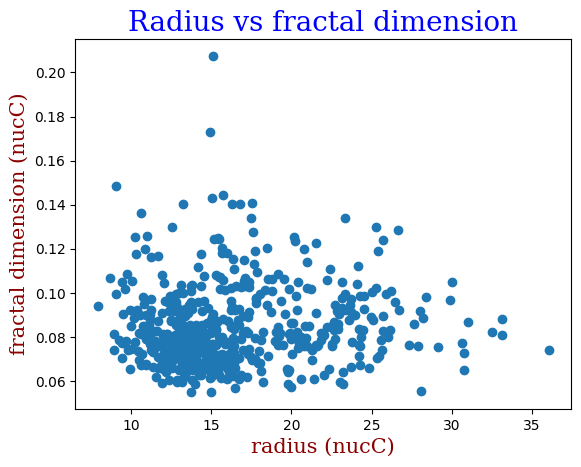

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

x = np.array(bcancer[['radius (nucC)']])
y = np.array(bcancer[['fractal dimension (nucC)']])
#sizes = np.array([20,50,100,200,500,1000,60,90,10,300,600,800,75])
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}

plt.xlabel("radius (nucC)", fontdict = font2)
plt.ylabel("fractal dimension (nucC)", fontdict = font2)
plt.title("Radius vs fractal dimension", fontdict = font1)

plt.scatter(bcancer[['radius (nucC)']], bcancer[['fractal dimension (nucC)']])

#slope, intercept, r, p, std_err = stats.linregress(x, y)
#
#def myfunc(x):
#  return slope * x + intercept
#
#mymodel = list(map(myfunc, x))

#plt.scatter(x, y)
#plt.plot(x, mymodel)

plt.show() 